# DNA shape features for k-mer nucleotide mutation rate prediction
## Preliminary data analysis
### Zian Liu
#### Last updated: 4/5/2022


This is a sub-module for data generation and preliminary data analysis.

## Setup

First, import libraries:

In [2]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools as it
import seaborn as sns
from joblib import dump, load, Parallel, delayed
from copy import deepcopy
from collections import Counter
from IPython.display import display
from Bio import SeqIO, motifs
from Bio.Seq import Seq
import eli5
from scipy.stats import pearsonr, spearmanr, fisher_exact, binom_test, kstest, percentileofscore, entropy
from statsmodels.stats.multitest import multipletests
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, roc_curve, roc_auc_score, auc
from sklearn.feature_selection import VarianceThreshold, f_regression
from sklearn.model_selection import cross_validate, KFold, GridSearchCV
from sklearn.linear_model import LinearRegression, LassoLarsIC, Lasso, lars_path
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree

# Print version info
import Bio
import matplotlib
import joblib
import scipy
import sklearn
print("Numpy version: ", np.__version__, "\nPandas version: ", pd.__version__, "\nMatplotlib version: ", matplotlib.__version__, 
      "\nSeaborn version: ", sns.__version__, "\nScipy version: ", scipy.__version__, "\nScikit-learn version: ", sklearn.__version__, 
      "\nBiopython version: ", Bio.__version__, "\nJoblib version: ", joblib.__version__, "\neli5 version: ", eli5.__version__)

Numpy version:  1.20.3 
Pandas version:  1.3.4 
Matplotlib version:  3.4.3 
Seaborn version:  0.11.2 
Scipy version:  1.7.1 
Scikit-learn version:  0.24.2 
Biopython version:  1.79 
Joblib version:  1.1.0 
eli5 version:  0.11.0


Import functions from file:

In [1]:
from notebook_functions_all import *

Create or load the files:

In [2]:
# Load files
flag_joblib_int_true = True

if flag_joblib_int_true:   # Skip data import and use the joblib file instea
    # Data reload
    DF_val_join, List_value, Eff_test, Index_class, Index_class_name, Pred_1d, Pred_2d, Minmax_shape, Eff, \
        Labels_2d, Kfoldobj, Pred_2dneibr, Labels_2dneibr, Minmax_2dneibr, Var_red_neibr, \
        Pred_sc_1d, Pred_sc_2d, Labels_sc_2d, Pred_sc_3d, \
        Labels_sc_3d, Pred_sc_4d, Labels_sc_4d, Index_class_sc, \
        Pred_sc_2dneibr, Labels_sc_2dneibr, Pred_sc_3dneibr, Labels_sc_3dneibr, \
        Pred_sc_4dneibr, Labels_sc_4dneibr = load("data_intermediate/import_all_data.joblib")
    
else:   # Run the data import step
    # Load files
    F_strucref = pd.ExcelFile("data_input/ref_7mers_structure_cpg.xlsx")
    Shapes_name = ['HelT', 'Rise', 'Roll', 'Shift', 'Slide', 'Tilt', 'Buckle', 'Opening', 'ProT', 'Shear', 
                     'Stagger', 'Stretch', 'MGW', 'EP']

    DF_strucval = pd.DataFrame()
    for item in Shapes_name:
        Temp_df = F_strucref.parse(sheet_name=item, index_col=0)
        if np.shape(Temp_df)[1] == 3:
            Temp_df.rename({'V1': item+'_L', 'V2': item+'_C', 'V3': item+'_R'}, axis='columns', inplace=True)
        else:
            Temp_df.rename({'V1': item+'_L', 'V2': item+'_CL', 'V3': item+'_CR', 'V4': item+'_R'}, axis='columns', inplace=True)
        DF_strucval = pd.concat([DF_strucval, Temp_df], axis=1)
        
    # Parse the count files and translate sequences to shape features
    # Index classes will map from 0-8 to A>C, A>G, A>T, C>A, C>G, C>T, CpG C>A, CpG C>G, CpG C>T
    # Input file is directly from Dr. Ben Voight's GitHub page
    DF_val_join, List_value, Eff_test, Index_class = load_file_preprocessed(
        "data_input/ben_data_7mer_bayesian_test_training_AFR_10", 
        mode='shape', structural_ref_df=DF_strucval)
    Index_class_name = ['A>C', 'A>G', 'A>T', 'C>A', 'C>G', 'C>T', 'CpG_C>A', 'CpG_C>G', 'CpG_C>T']

    # Do some preprocessing to create predictors
    # 1st order shape predictors
    Pred_1d = MinMaxScaler(feature_range=(0, 1)).fit_transform(DF_val_join)
    print(np.shape(Pred_1d))   # return shape
    # 2nd degree interaction terms
    Pred_2d = PolynomialFeatures(degree=2, include_bias=False).fit_transform(DF_val_join)
    Minmax_shape = MinMaxScaler(feature_range=(0, 1)).fit(Pred_2d)
    Pred_2d = Minmax_shape.transform(Pred_2d)
    print(np.shape(Pred_2d))   # return shape
    # Effector
    Eff = np.array(List_value)

    # Labels
    Labels_2d, temp_labels = list(DF_val_join.columns), DF_val_join.columns
    for i in range(np.shape(DF_val_join)[1]):
        for j in range(i, np.shape(DF_val_join)[1]):
            Labels_2d.append(temp_labels[i]+'*'+temp_labels[j])
    print(Labels_2d[0:10])
    print(len(Labels_2d))

    # Stratified k-fold
    Kfoldobj = KFold(n_splits=8, shuffle=True, random_state=42)
    
    # Remove low-variance features
    # Reduce variance
    Var_red = VarianceThreshold(threshold=0.01).fit(Pred_2d)
    print(Var_red.get_params())
    Pred_2d = Var_red.transform(Pred_2d)
    print(np.shape(Pred_2d))

    # Labels
    Labels_2d = Var_red.transform(np.array(Labels_2d).reshape(1, 4752))[0]
    print(len(Labels_2d))
    
    # Make 2D predictor with only neighboring interactions
    temp_labels = DF_val_join.columns
    Pred_2dneibr = make_2dshape_neighbor(DF_val_join, temp_labels)

    # Minmax scaling
    Labels_2dneibr = Pred_2dneibr.columns
    Minmax_2dneibr = MinMaxScaler(feature_range=(0, 1)).fit(Pred_2dneibr)
    Pred_2dneibr = Minmax_2dneibr.transform(Pred_2dneibr)
    print(np.shape(Pred_2dneibr))

    # Reduce variance
    Var_red_neibr = VarianceThreshold(threshold=0.01).fit(Pred_2dneibr)
    print(Var_red_neibr.get_params())
    Pred_2dneibr = Var_red_neibr.transform(Pred_2dneibr)
    Labels_2dneibr = Var_red_neibr.transform(np.array(Labels_2dneibr).reshape(1, len(Labels_2dneibr)))[0]
    print(np.shape(Pred_2dneibr))
    
    # Import sequence context predictors
    Pred_raw, foo, goo, Index_class_sc = load_file_preprocessed(
        "data_input/ben_data_7mer_bayesian_test_training_AFR_10", 
        mode='sequence', structural_ref_df=DF_strucval)

    cat = [['C','G','T'], ['C','G','T'],['C','G','T'],['C','G','T'],['C','G','T'],['C','G','T']]
    Pred_sc_1d = OneHotEncoder(categories=cat, sparse=True, handle_unknown='ignore').fit_transform(Pred_raw).toarray()

    Pred_sc_2d, Labels_sc_2d = make_4dshape(Pred_sc_1d, Pred_raw, degree=2)
    Pred_sc_3d, Labels_sc_3d = make_4dshape(Pred_sc_1d, Pred_raw, degree=3)
    Pred_sc_4d, Labels_sc_4d = make_4dshape(Pred_sc_1d, Pred_raw, degree=4)

    print(np.shape(Pred_sc_4d))
    print(Labels_sc_4d[0:10])
    display(Pred_sc_4d)
    
    # Make 4D sequence context predictors with only neighbors to compare performance later on
    Pred_sc_2dneibr, Labels_sc_2dneibr = make_4dshape(Pred_sc_1d, Pred_raw, degree=2, neighbors_only=True)
    Pred_sc_3dneibr, Labels_sc_3dneibr = make_4dshape(Pred_sc_1d, Pred_raw, degree=3, neighbors_only=True)
    Pred_sc_4dneibr, Labels_sc_4dneibr = make_4dshape(Pred_sc_1d, Pred_raw, degree=4, neighbors_only=True)
    
    # Save setup
    dump([DF_val_join, List_value, Eff_test, Index_class, Index_class_name, Pred_1d, Pred_2d, Minmax_shape, Eff, Labels_2d, 
          Kfoldobj, Pred_2dneibr, Labels_2dneibr, Minmax_2dneibr, Var_red_neibr, 
          Pred_sc_1d, Pred_sc_2d, Labels_sc_2d, Pred_sc_3d, 
          Labels_sc_3d, Pred_sc_4d, Labels_sc_4d, Index_class_sc, 
          Pred_sc_2dneibr, Labels_sc_2dneibr, Pred_sc_3dneibr, Labels_sc_3dneibr, 
          Pred_sc_4dneibr, Labels_sc_4dneibr], "data_intermediate/import_all_data.joblib")

This concludes the setup. Next, do some baseline analysis:

## Baseline analysis

Start with analyzing the distribution of mutation rates, draw by class.

In [6]:
F_rateall = get_bayesian_dict_rate_file("data_input/non_coding_all_AFR_before3_after3_folded_all")
_, List_value_plot = load_files(F_rateall, DF_strucval, 'combined', return_df='combined')
Index_class_rateall = create_class_index(list(F_rateall['combined'].keys()))

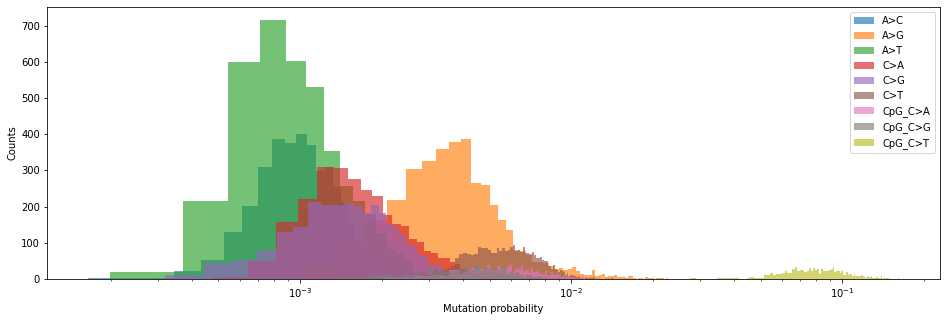

In [10]:
fig_temp = plt.figure(figsize=[16,5])
for item in set(Index_class):
    temp = np.array(List_value_plot)[Index_class_rateall == item]
    plt.hist(temp[temp != 0], bins=100, alpha=0.65)
plt.xlabel("Mutation probability")
plt.xscale('log')
plt.ylabel("Counts")
plt.legend(Index_class_name)
plt.show()
#fig_temp.savefig("manuscript/figures/pltout_fig1a_mutprobs.pdf", dpi=300)

Print the fold change of most/least mutable sequence mutation rates:

In [11]:
for item in set(Index_class):
    temp = np.array(List_value_plot)[Index_class_rateall == item]
    print("Class "+str(item), max(temp)/min(temp))

Class 0 55.32645660345056
Class 1 37.04535962413463
Class 2 87.5569686150219
Class 3 58.5564037875561
Class 4 40.55038324481904
Class 5 6.1241608073986775
Class 6 10.185133446070143
Class 7 9.679010026533918
Class 8 7.4052567000322895


plot one mutation class:

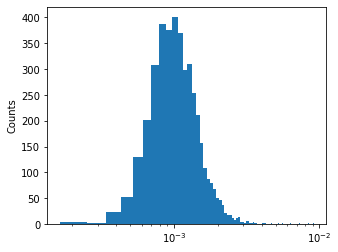

In [12]:
fig_temp = plt.figure(figsize=[5, 4])
temp = np.array(List_value_plot)[Index_class_rateall == 0]
plt.hist(temp[temp != 0], bins=100, alpha=1)
plt.xscale('log')
plt.ylabel("Counts")
plt.show()
fig_temp.savefig("manuscript/figures/pltout_misc_mutprobAC.jpg", dpi=300)

Next, find out the distribution of substitution rates in each of the classes:

[[1.19122724e-03 5.19521877e-04 2.69902981e-07]
 [4.88953433e-03 3.26950839e-03 1.06896851e-05]
 [1.16443245e-03 6.20821655e-04 3.85419527e-07]
 [2.15367812e-03 1.26584806e-03 1.60237132e-06]
 [1.87805477e-03 9.83684581e-04 9.67635356e-07]
 [6.26126368e-03 1.85155779e-03 3.42826625e-06]
 [6.20661762e-03 2.13363395e-03 4.55239381e-06]
 [4.87207807e-03 1.70868428e-03 2.91960196e-06]
 [8.63820713e-02 2.31719640e-02 5.36939916e-04]]


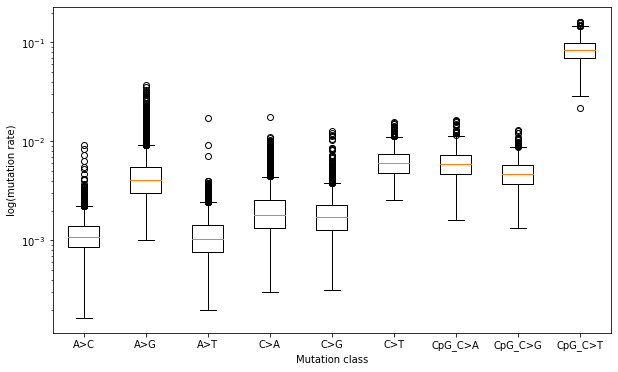

In [13]:
temp_metrics = np.zeros(shape=(9, 3), dtype=float)

fig_temp = plt.figure(figsize=[10, 6])
temp_plt = []
for item in set(Index_class):
    temp_plt.append(np.array(List_value_plot)[Index_class_rateall == item])
    temp_metrics[item] = np.mean(temp_plt[item]), np.std(temp_plt[item]), np.var(temp_plt[item])
print(temp_metrics)
plt.boxplot(temp_plt)
plt.xticks(np.arange(1, 10), Index_class_name)
plt.yscale('log')
plt.xlabel("Mutation class")
plt.ylabel("log(mutation rate)")
plt.show()
fig_temp.savefig("manuscript/figures/pltout_subprobs_bar.pdf", dpi=300)

Next, analyze inter-chromosomal correlation, overall or by subclass:

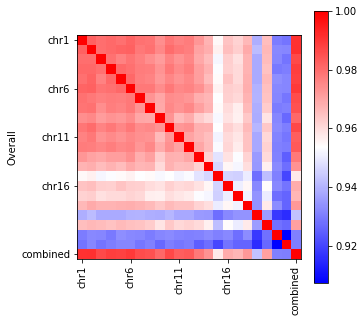

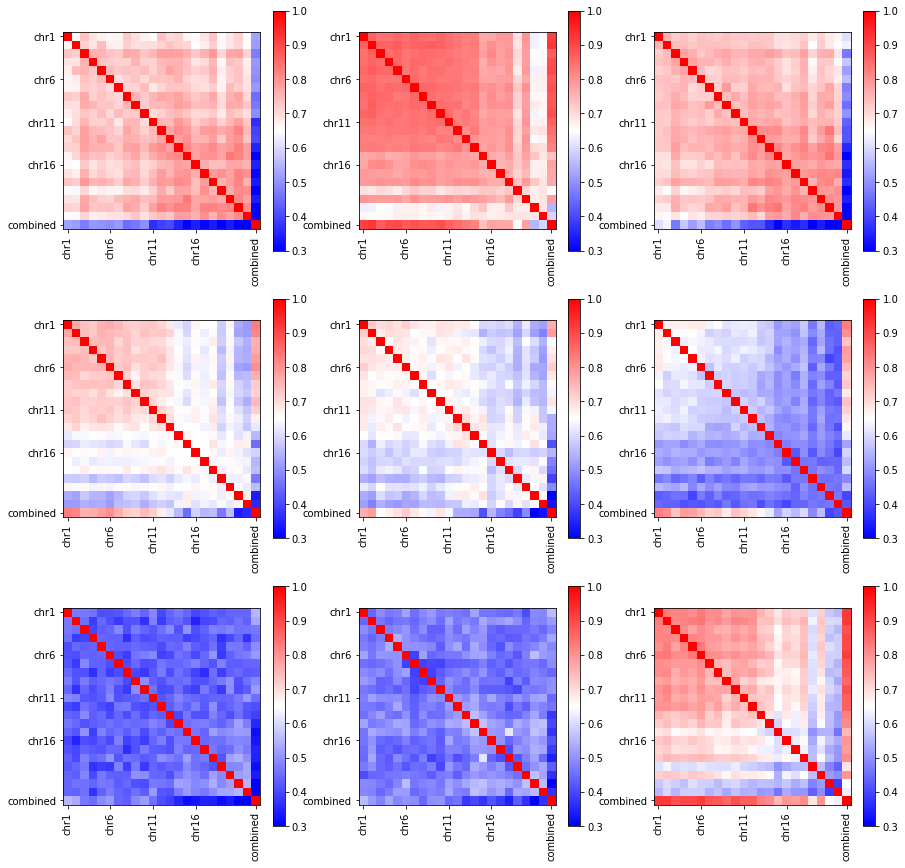

In [14]:
Array_all_chr_values = np.zeros(shape=(23, len(Eff)))
for chr_no in range(1, 24):
    if chr_no != 23:
        Array_all_chr_values[chr_no-1] = np.array(list(F_rateall[str(chr_no)].values()))
    else:
        Array_all_chr_values[chr_no-1] = np.array(list(F_rateall['combined'].values()))

temp_fig1 = plt.figure(figsize=[5,5])
temp = np.corrcoef(Array_all_chr_values)
plt.imshow(temp, cmap='bwr')
plt.colorbar()
plt.xticks([0, 5, 10, 15, 22], ['chr1', 'chr6', 'chr11', 'chr16', 'combined'], rotation=90)
plt.yticks([0, 5, 10, 15, 22], ['chr1', 'chr6', 'chr11', 'chr16', 'combined'])
plt.ylabel("Overall")
plt.show()
temp_fig1.savefig("manuscript/figures/pltout_interchrcorr.pdf", dpi=300)

temp_fig2 = plt.figure(figsize=[15, 15])
for item in set(Index_class_rateall):
    plt.subplot(3,3,item+1)
    temp = np.corrcoef(np.transpose(np.transpose(Array_all_chr_values)[Index_class_rateall == item]))
    plt.imshow(temp, cmap='bwr')
    plt.colorbar()
    plt.clim(0.3, 1)
    plt.xticks([0, 5, 10, 15, 22], ['chr1', 'chr6', 'chr11', 'chr16', 'combined'], rotation=90)
    plt.yticks([0, 5, 10, 15, 22], ['chr1', 'chr6', 'chr11', 'chr16', 'combined'])
plt.show()
temp_fig2.savefig("manuscript/figures/pltout_interchrcorr_byclass.pdf", dpi=300)

We can see that the mutation rates vary a lot across chromosomes; this explains why we want to combine all odds/all evens as testing/training. 

Next, plot correlation between the 96 shape features:

In [ ]:
temp_fig = plt.figure(figsize=[12, 12])
temp = np.corrcoef(DF_strucval, rowvar=False)
plt.imshow(temp, cmap='bwr')
plt.colorbar(label="Pearson correlation")
plt.clim(-1, 1)
plt.xticks(np.arange(np.shape(DF_strucval)[1]), list(DF_strucval.columns), rotation=90)
plt.yticks(np.arange(np.shape(DF_strucval)[1]), list(DF_strucval.columns))
plt.xlabel("Input features")
plt.ylabel("Input features")
plt.tight_layout()
plt.show()
temp_fig.savefig("manuscript/figures/pltout_sup10_shapecorr.pdf", dpi=300)

We can see that the shape features are for the most part pretty independent; the horizontal slashes show how some shapes are correlated.

Also plot the distribution of changes in DNA shapes in each mutation class, we will look primarily at the central location:

In [ ]:
temp_cols = [item for item in DF_val_join.columns if ((item.split("_")[1] in ["C", "CR", "CL"]) and ("_r" not in item))]
#temp_df = pd.DataFrame(Pred_1d, index = DF_val_join.index, columns = DF_val_join.columns)
temp_df = DF_val_join.copy()
temp_df = temp_df.loc[:, temp_cols]
temp_df = dict(temp_df)
# Combine CL and CR
for item in temp_df.keys():
    if "CR" in item:
        item_l = re.sub("CR", "CL", item)
        temp_df[item_l] = pd.concat([temp_df[item_l], temp_df[item]], axis=0, ignore_index=True)
temp_df = pd.DataFrame(dict([(key, pd.Series(value)) for key, value in temp_df.items()]))
temp_df = temp_df.loc[:, [item for item in temp_df.columns if "CR" not in item]]

#fig_temp = plt.figure(figsize=[20,3], )
fig_temp = plt.figure(figsize=[20, 10])
sns.violinplot(data=temp_df)
plt.show()
fig_temp.savefig("manuscript/figures/pltout_shapedist_central.pdf", dpi=300)

Do this per-figure:

In [ ]:
temp_cols = [item for item in DF_val_join.columns if ((item.split("_")[1] in ["C", "CR", "CL"]) and ("_r" not in item))]
#temp_df = pd.DataFrame(Pred_1d, index = DF_val_join.index, columns = DF_val_join.columns)
temp_df = DF_val_join.copy()
temp_df = temp_df.loc[:, temp_cols]
temp_df = dict(temp_df)
# Combine CL and CR
for item in temp_df.keys():
    if "CR" in item:
        item_l = re.sub("CR", "CL", item)
        temp_df[item_l] = pd.concat([temp_df[item_l], temp_df[item]], axis=0, ignore_index=True)
temp_df = pd.DataFrame(dict([(key, pd.Series(value)) for key, value in temp_df.items()]))
temp_df = temp_df.loc[:, [item for item in temp_df.columns if "CR" not in item]]

#fig_temp = plt.figure(figsize=[20,3], )
fig_temp, ax = plt.subplots(figsize=[20, 3], ncols=temp_df.shape[1])
for i in range(temp_df.shape[1]):
    sns.violinplot(data=temp_df.iloc[:, i], ax=ax[i])
    ax[i].set_xlabel(temp_df.columns.values[i])
plt.show()
fig_temp.savefig("manuscript/figures/pltout_shapedist_central.pdf", dpi=300)

By mutation class:

In [ ]:
temp_cols = [item for item in DF_val_join.columns if ((item.split("_")[1] in ["C", "CR", "CL"]) and ("_r" not in item))]
#temp_df = pd.DataFrame(Pred_1d, index = DF_val_join.index, columns = DF_val_join.columns)
temp_df = DF_val_join.copy()
temp_df = temp_df.loc[:, temp_cols]

fig, ax = plt.subplots(figsize=[20, 20], nrows=9, ncols=1, sharex=True)
# Perform the rest by class
for select in set(Index_class_rateall):
    temp_df_class = temp_df.loc[Index_class_rateall == select]
    temp_df_class = dict(temp_df_class)
    # Combine CL and CR
    for item in temp_df_class.keys():
        if "CR" in item:
            item_l = re.sub("CR", "CL", item)
            temp_df_class[item_l] = pd.concat([temp_df_class[item_l], temp_df_class[item]], axis=0, ignore_index=True)
    temp_df_class = pd.DataFrame(dict([(key, pd.Series(value)) for key, value in temp_df_class.items()]))
    temp_df_class = temp_df_class.loc[:, [item for item in temp_df_class.columns if "CR" not in item]]
    sns.violinplot(data=temp_df_class, ax=ax[select])
    ax[select].set_title(select)
    
plt.show()
fig.savefig("manuscript/figures/pltout_shapedist_central_bymutclass.pdf", dpi=300)

This concludes this notebook section. Next, progress to model building.